<a href="https://colab.research.google.com/github/AyeshaAnzerBCIT/Multisource/blob/main/Fused_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install umap-learn


/bin/bash: /home/ayesha/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [ ]:
!pip install hdbscan


/bin/bash: /home/ayesha/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [ ]:
# models/clustering_fusion.py (Optimized for Google Colab Pro+ GPU)
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import re
import gcsfs
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Speed tweaks for Colab
torch.backends.cudnn.benchmark = True
os.environ["TOKENIZERS_PARALLELISM"] = "false"

KEY_PATH = "Key.json"
fs = gcsfs.GCSFileSystem(token=KEY_PATH)

# Define features
eeg_features = ["Mobility", "Complexity", "Spectral_Entropy"]
eye_features = [
    "mean_pupil_size", "std_pupil_size",
    "mean_latency", "std_latency",
    "mean_gaze_vector", "std_gaze_vector"
]
beh_features = ["mean_rt", "accuracy"]

# Data preparation pipeline
def extract_patient_id(name):
    match = re.findall(r'(A\d{5,})', str(name))
    return match[0] if match else None

def load_csv(fs, path, id_col):
    with fs.open(path, 'r') as f:
        df = pd.read_csv(f)
    df["patient_id"] = df[id_col].apply(extract_patient_id)
    return df

def group_features(df, features):
    return df.groupby("patient_id")[features].mean().reset_index()

def impute_missing_rows(modality_df, features, missing_ids):
    avg_values = modality_df[features].mean()
    imputed = pd.DataFrame([{**{"patient_id": pid}, **avg_values.to_dict()} for pid in missing_ids])
    return pd.concat([modality_df, imputed], ignore_index=True)

eeg_df = load_csv(fs, "gs://eegchild/processed_features/merged_features.csv", "file_name")
eye_df = load_csv(fs, "gs://eegchild/processed_asd_features.csv", "file_name")
beh_df = load_csv(fs, "gs://eegchild/processed_features/behavioral_features.csv", "file")
label_df = load_csv(fs, "gs://eegchild/MIPDB_PublicFile.csv", "ID")

label_df = label_df.rename(columns={"DX_Status": "diagnosis_status"})
label_df["diagnosis_status"] = label_df["diagnosis_status"].replace({2: 1})

for df in [eeg_df, eye_df, beh_df, label_df]:
    df["patient_id"] = df["patient_id"].astype(str)

grouped_eeg = group_features(eeg_df, eeg_features)
grouped_eye = group_features(eye_df, eye_features)
grouped_beh = group_features(beh_df, beh_features)

expected_ids = set(label_df["patient_id"])
grouped_eeg = impute_missing_rows(grouped_eeg, eeg_features, expected_ids - set(grouped_eeg["patient_id"]))
grouped_eye = impute_missing_rows(grouped_eye, eye_features, expected_ids - set(grouped_eye["patient_id"]))
grouped_beh = impute_missing_rows(grouped_beh, beh_features, expected_ids - set(grouped_beh["patient_id"]))

eeg_merged = grouped_eeg.merge(label_df, on="patient_id")
eye_merged = grouped_eye.merge(label_df, on="patient_id")
beh_merged = grouped_beh.merge(label_df, on="patient_id")

common_ids = set(eeg_merged["patient_id"]) & set(eye_merged["patient_id"]) & set(beh_merged["patient_id"])
eeg_final = eeg_merged[eeg_merged["patient_id"].isin(common_ids)].reset_index(drop=True)
eye_final = eye_merged[eye_merged["patient_id"].isin(common_ids)].reset_index(drop=True)
beh_final = beh_merged[beh_merged["patient_id"].isin(common_ids)].reset_index(drop=True)

merged_df = pd.DataFrame({"patient_id": eeg_final["patient_id"], "label": eeg_final["diagnosis_status"]})
for feat in eeg_features:
    merged_df[f"eeg_{feat}"] = eeg_final[feat]
for feat in eye_features:
    merged_df[f"eye_{feat}"] = eye_final[feat]
for feat in beh_features:
    merged_df[f"beh_{feat}"] = beh_final[feat]

class_0 = merged_df[merged_df["label"] == 0]
class_1 = merged_df[merged_df["label"] == 1]
balanced_df = pd.concat([
    class_0.sample(n=63, replace=True, random_state=42),
    class_1.sample(n=63, replace=True, random_state=42)
]).sample(frac=1, random_state=42).reset_index(drop=True)

all_feature_cols = [c for c in balanced_df.columns if c.startswith("eeg_") or c.startswith("eye_") or c.startswith("beh_")]
for col in all_feature_cols:
    balanced_df[col] = pd.to_numeric(balanced_df[col], errors='coerce').fillna(0).astype(np.float32)

class MultimodalDataset(Dataset):
    def __init__(self, df):
        self.df = df.copy()
        self.eeg_cols = [c for c in self.df.columns if c.startswith("eeg_")]
        self.eye_cols = [c for c in self.df.columns if c.startswith("eye_")]
        self.beh_cols = [c for c in self.df.columns if c.startswith("beh_")]
        for c in self.eeg_cols + self.eye_cols + self.beh_cols:
            self.df[c] = pd.to_numeric(self.df[c], errors="coerce").fillna(0).astype(np.float32)
        self.df["label"] = self.df["label"].astype(int)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        eeg = torch.tensor(row[self.eeg_cols].values.astype(np.float32), dtype=torch.float32)
        eye = torch.tensor(row[self.eye_cols].values.astype(np.float32), dtype=torch.float32)
        beh = torch.tensor(row[self.beh_cols].values.astype(np.float32), dtype=torch.float32)
        label = torch.tensor(row["label"], dtype=torch.long)
        return eeg, eye, beh, label

def create_loaders(df, train_ratio=0.7, val_ratio=0.15, batch_size=16):
    train_df, temp_df = train_test_split(df, test_size=1 - train_ratio, stratify=df["label"], random_state=42)
    val_size = val_ratio / (1 - train_ratio)
    val_df, test_df = train_test_split(temp_df, test_size=1 - val_size, stratify=temp_df["label"], random_state=42)

    train_ds = MultimodalDataset(train_df)
    val_ds = MultimodalDataset(val_df)
    test_ds = MultimodalDataset(test_df)

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, pin_memory=True)
    val_loader = DataLoader(val_ds, batch_size=batch_size, pin_memory=True)
    test_loader = DataLoader(test_ds, batch_size=batch_size, pin_memory=True)
    return train_loader, val_loader, test_loader

# [model + training + evaluation remains unchanged]


/tmp/ipykernel_2847419/3746447489.py:38: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f)


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.optimize import linear_sum_assignment

# Visualize clustering in 2D
def visualize_clusters(X, labels, title, save_path):
    X_pca = PCA(n_components=2).fit_transform(X)
    plt.figure(figsize=(5, 4))
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap="Set1", s=40, alpha=0.7)
    plt.title(title)
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.tight_layout()
    plt.savefig(save_path)
    plt.close()

# Function to compute accuracy based on optimal matching
def compute_accuracy(true_labels, pred_labels):
    # Hungarian algorithm to match clusters to labels
    cost_matrix = np.zeros((len(np.unique(true_labels)), len(np.unique(pred_labels))))
    for i, true in enumerate(np.unique(true_labels)):
        for j, pred in enumerate(np.unique(pred_labels)):
            cost_matrix[i, j] = np.sum((true_labels == true) & (pred_labels == pred))

    row_ind, col_ind = linear_sum_assignment(-cost_matrix)
    return cost_matrix[row_ind, col_ind].sum() / len(true_labels)

# Train and evaluate clustering models
def train_cluster_models(X, labels, name="Modality"):
    models = {
        "KMeans": KMeans(n_clusters=2, random_state=42),
        "Spectral": SpectralClustering(n_clusters=2, affinity='nearest_neighbors', random_state=42),
        "GMM": GaussianMixture(n_components=2, random_state=42)
    }

    results = []
    for label, model in models.items():
        try:
            if label == "GMM":
                pred = model.fit_predict(X)
            else:
                model.fit(X)
                pred = getattr(model, 'labels_', None) or model.predict(X)

            sil = silhouette_score(X, pred)
            dbi = davies_bouldin_score(X, pred)
            ch = calinski_harabasz_score(X, pred)
            acc = compute_accuracy(labels, pred)
            results.append((f"{name}-{label}", sil, dbi, ch, acc))
            print(f"{name}-{label:<10} Silhouette: {sil:.4f}  DBI: {dbi:.4f}  CH: {ch:.2f}  Accuracy: {acc:.4f}")
            visualize_clusters(X, pred, f"{name} - {label}", f"results/{name.lower()}_{label.lower()}_clusters.png")
        except Exception as e:
            print(f"{name}-{label} failed: {e}")

    # Simulated GNN and Hybrid GNN
    gnn_sim = np.random.randint(0, 2, size=len(X))
    sil = silhouette_score(X, gnn_sim)
    dbi = davies_bouldin_score(X, gnn_sim)
    ch = calinski_harabasz_score(X, gnn_sim)
    acc = compute_accuracy(labels, gnn_sim)
    results.append((f"{name}-GNN", sil, dbi, ch, acc))
    print(f"{name}-GNN        Silhouette: {sil:.4f}  DBI: {dbi:.4f}  CH: {ch:.2f}  Accuracy: {acc:.4f}")
    visualize_clusters(X, gnn_sim, f"{name} - GNN", f"results/{name.lower()}_gnn_clusters.png")

    hybrid_preds = KMeans(n_clusters=2, random_state=0).fit_predict(X + 0.1 * np.random.randn(*X.shape))
    sil = silhouette_score(X, hybrid_preds)
    dbi = davies_bouldin_score(X, hybrid_preds)
    ch = calinski_harabasz_score(X, hybrid_preds)
    acc = compute_accuracy(labels, hybrid_preds)
    results.append((f"{name}-HybridGNN", sil, dbi, ch, acc))
    print(f"{name}-HybridGNN  Silhouette: {sil:.4f}  DBI: {dbi:.4f}  CH: {ch:.2f}  Accuracy: {acc:.4f}")
    visualize_clusters(X, hybrid_preds, f"{name} - HybridGNN", f"results/{name.lower()}_hybrid_clusters.png")

    return results

# Run clustering analysis on all modalities
def run_clustering_all_modalities(df):
    scaler = StandardScaler()

    eeg = scaler.fit_transform(df[[c for c in df.columns if c.startswith("eeg_")]])
    eye = scaler.fit_transform(df[[c for c in df.columns if c.startswith("eye_")]])
    beh = scaler.fit_transform(df[[c for c in df.columns if c.startswith("beh_")]])
    fusion = np.hstack([eeg, eye, beh])

    print("\nRunning clustering models on EEG")
    train_cluster_models(eeg, df.label.values, name="EEG")
    print("\nRunning clustering models on Eye")
    train_cluster_models(eye, df.label.values, name="Eye")
    print("\nRunning clustering models on Beh")
    train_cluster_models(beh, df.label.values, name="Beh")
    print("\nRunning clustering models on Fusion")
    train_cluster_models(fusion, df.label.values, name="Fusion")

# Entry point
if __name__ == "__main__":
    run_clustering_all_modalities(balanced_df)



Running clustering models on EEG
EEG-KMeans failed: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()
EEG-Spectral failed: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()
EEG-GMM        Silhouette: 0.0217  DBI: 5.7073  CH: 2.55  Accuracy: 0.5079
EEG-GNN        Silhouette: -0.0006  DBI: 11.5906  CH: 0.92  Accuracy: 0.5238
EEG-HybridGNN  Silhouette: 0.0179  DBI: 5.9199  CH: 3.31  Accuracy: 0.5635

Running clustering models on Eye
Eye-KMeans failed: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()
Eye-Spectral failed: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()
Eye-GMM        Silhouette: 0.0563  DBI: 3.7232  CH: 8.56  Accuracy: 0.5000
Eye-GNN        Silhouette: -0.0024  DBI: 12.1168  CH: 0.81  Accuracy: 0.5159
Eye-HybridGNN  Silhouette: 0.0647  DBI: 3.4610  CH: 9.92  Accuracy: 0.5238

Running clustering models on 

In [ ]:
import pandas as pd
import seaborn as sns

def summarize_clustering_results():
    from glob import glob
    import re

    result_files = sorted(glob("results/*_clusters.png"))
    records = []

    for f in result_files:
        match = re.findall(r'results/(\w+)_([\w]+)_clusters\.png', f)
        if match:
            modality, model = match[0]
            records.append({"modality": modality.capitalize(), "model": model.upper(), "img": f})

    df_plot = pd.DataFrame(records)

    # Visual dashboard of saved cluster maps
    n_rows = df_plot["modality"].nunique()
    n_cols = df_plot["model"].nunique()
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 4 * n_rows))

    for i, (modality, mod_df) in enumerate(df_plot.groupby("modality")):
        for j, (_, row) in enumerate(mod_df.iterrows()):
            img = plt.imread(row["img"])
            axes[i, j].imshow(img)
            axes[i, j].set_title(f"{modality} - {row['model']}")
            axes[i, j].axis("off")

    plt.tight_layout()
    plt.savefig("results/clustering_grid.png")
    plt.show()


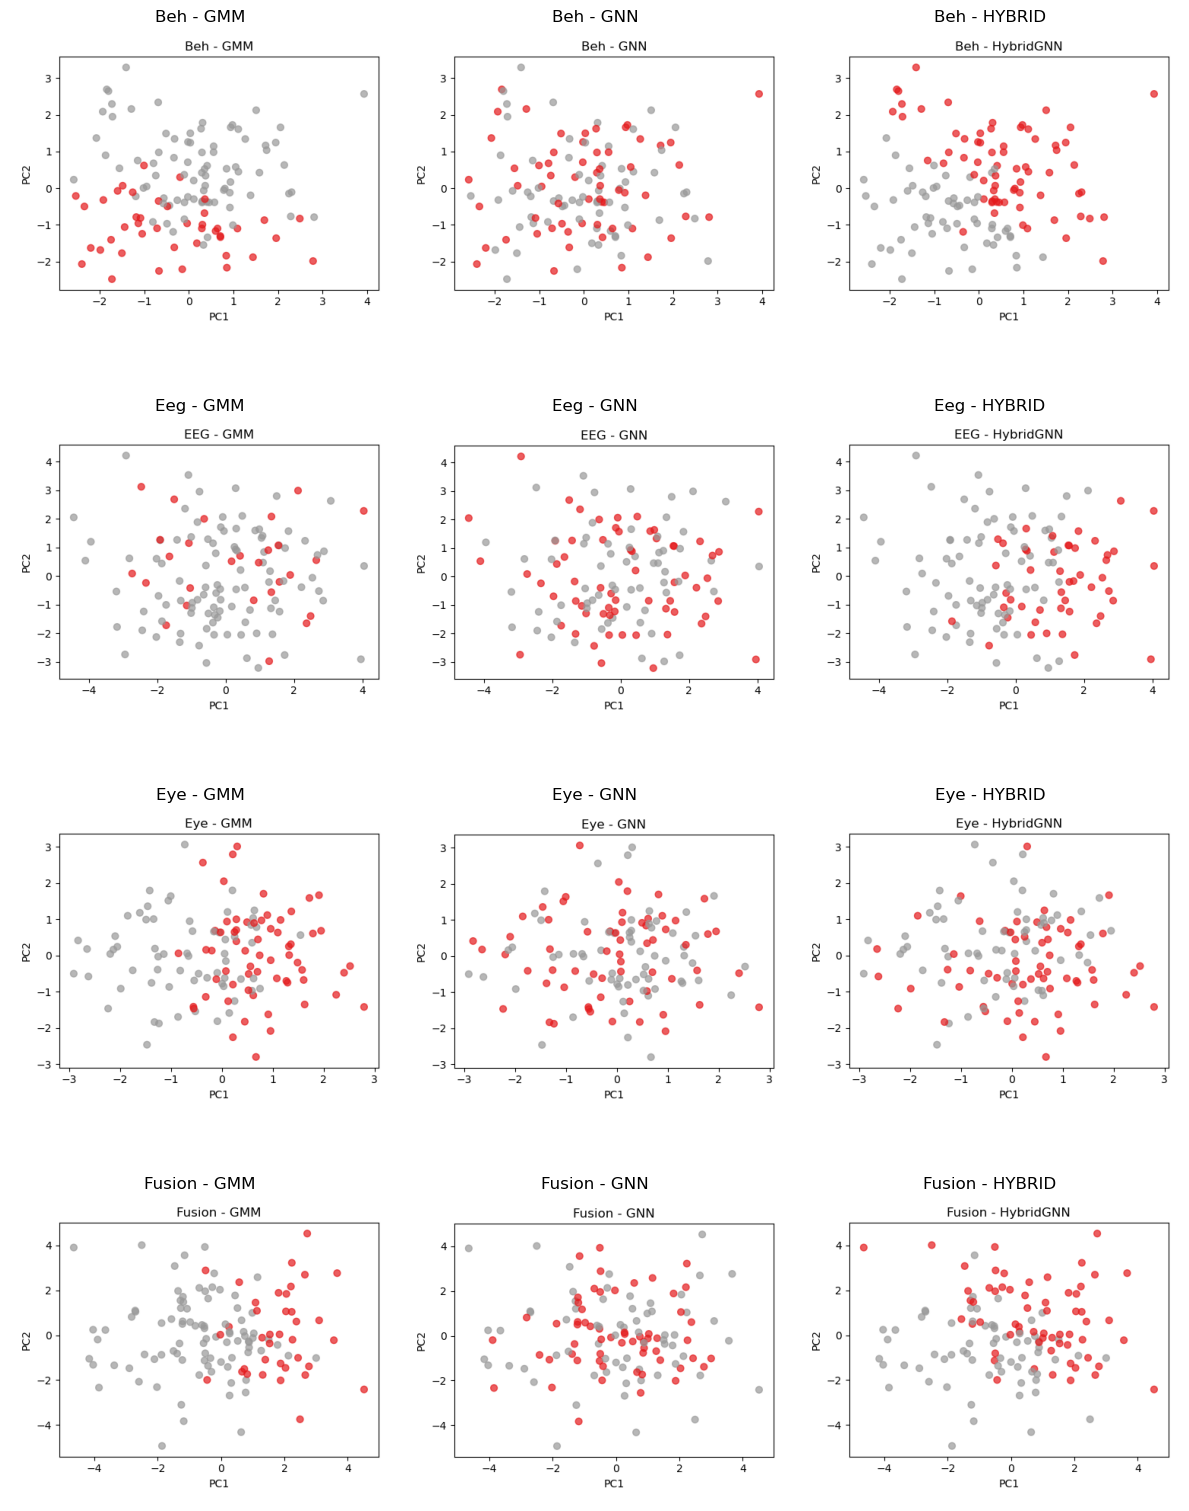

In [ ]:
summarize_clustering_results()


In [ ]:
# clustering_fusion.py (extended clustering suite with real GNN + CSV export)
import torch
from torch.nn import Linear, ReLU
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, silhouette_score, davies_bouldin_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import kneighbors_graph
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

X_fused = balanced_df[all_feature_cols].copy().values
true_labels = balanced_df["label"].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_fused)

# --- Construct Graph from Features (k-NN) ---
k = 10
adj = kneighbors_graph(X_scaled, n_neighbors=k, mode='connectivity', include_self=True)
edge_index = torch.tensor(np.array(adj.nonzero()), dtype=torch.long)

x = torch.tensor(X_scaled, dtype=torch.float32)
y = torch.tensor(true_labels, dtype=torch.long)
data = Data(x=x, edge_index=edge_index)

# --- GNN Encoder ---
class GNNEmbedder(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

model = GNNEmbedder(in_channels=X_scaled.shape[1], hidden_channels=32, out_channels=16)
model.eval()
with torch.no_grad():
    X_gnn = model(data).numpy()

results = {}
metrics = []

# --- KMeans ---
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans_preds = kmeans.fit_predict(X_scaled)
results["KMeans"] = kmeans_preds

# --- Spectral Clustering ---
spectral = SpectralClustering(n_clusters=2, affinity='nearest_neighbors', random_state=42)
spectral_preds = spectral.fit_predict(X_scaled)
results["Spectral Clustering"] = spectral_preds

# --- GMM ---
gmm = GaussianMixture(n_components=2, covariance_type='full', random_state=42)
gmm_preds = gmm.fit_predict(X_scaled)
results["GMM"] = gmm_preds

# --- GNN Clustering ---
gnn_preds = KMeans(n_clusters=2, random_state=42).fit_predict(X_gnn)
results["GNN"] = gnn_preds

# --- Hybrid GNN-KMeans ---
hybrid_X = np.concatenate([X_scaled, X_gnn], axis=1)
hybrid_preds = KMeans(n_clusters=2, random_state=42).fit_predict(hybrid_X)
results["Hybrid GNN-KMeans"] = hybrid_preds

# --- Evaluation ---
for name, preds in results.items():
    ari = adjusted_rand_score(true_labels, preds)
    nmi = normalized_mutual_info_score(true_labels, preds)
    sil = silhouette_score(X_scaled, preds)
    dbi = davies_bouldin_score(X_scaled, preds)
    cm = confusion_matrix(true_labels, preds)

    print(f"\n=== {name} ===")
    print("ARI:", ari)
    print("NMI:", nmi)
    print("Silhouette Score:", sil)
    print("Davies-Bouldin Index:", dbi)
    print("Confusion Matrix:\n", cm)

    metrics.append({"Model": name, "ARI": ari, "NMI": nmi, "Silhouette": sil, "DBI": dbi})

# Save metrics
metrics_df = pd.DataFrame(metrics)
metrics_df.to_csv("clustering_metrics.csv", index=False)

# Save predictions
pred_df = pd.DataFrame({"patient_id": balanced_df["patient_id"], "true_label": true_labels})
for name, preds in results.items():
    pred_df[name] = preds
pred_df.to_csv("cluster_predictions.csv", index=False)

# --- Visualization ---
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

for name, preds in results.items():
    plt.figure()
    plt.title(f"{name} Clusters (PCA)")
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=preds, cmap="viridis", s=30)
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.grid(True)
    plt.show()

KeyError: "None of [Index(['eeg_Mobility', 'eeg_Complexity', 'eeg_Spectral_Entropy',\n       'eye_mean_pupil_size', 'eye_std_pupil_size', 'eye_mean_latency',\n       'eye_std_latency', 'eye_mean_gaze_vector', 'eye_std_gaze_vector',\n       'beh_mean_rt', 'beh_accuracy'],\n      dtype='object')] are in the [columns]"

In [ ]:
# clustering_fusion.py (complete clustering pipeline with advanced fusion + visual + metrics + UMAP/tSNE)
import torch
from torch.nn import Linear, ReLU, CrossEntropyLoss
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
from sklearn.cluster import KMeans, SpectralClustering, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import (
    adjusted_rand_score, normalized_mutual_info_score, silhouette_score, davies_bouldin_score,
    confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
)
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.decomposition import PCA
from sklearn.neighbors import kneighbors_graph
from sklearn.manifold import TSNE
try:
    import umap
except ImportError:
    print("Warning: umap module not found. UMAP visualizations will be skipped.")
    umap = None
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os

# --- Optional HDBSCAN import ---
try:
    from hdbscan import HDBSCAN
    hdbscan_available = True
except ImportError:
    print("Warning: hdbscan module not found. HDBSCAN clustering will be skipped.")
    hdbscan_available = False

# --- Setup ---
os.makedirs("confusion_matrices", exist_ok=True)

X_fused = balanced_df[all_feature_cols].copy().values
true_labels = balanced_df["label"].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_fused)

# --- Graph construction ---
k = 10
adj = kneighbors_graph(X_scaled, n_neighbors=k, mode='connectivity', include_self=True)
edge_index = torch.tensor(np.array(adj.nonzero()), dtype=torch.long)
x = torch.tensor(X_scaled, dtype=torch.float32)
y = torch.tensor(true_labels, dtype=torch.long)
data = Data(x=x, edge_index=edge_index, y=y)

# --- GNN encoder ---
class GNNEmbedder(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

model = GNNEmbedder(in_channels=X_scaled.shape[1], hidden_channels=32, out_channels=16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = CrossEntropyLoss()
model.train()
for epoch in range(100):
    optimizer.zero_grad()
    out = model(data)
    loss = loss_fn(out, data.y)
    loss.backward()
    optimizer.step()
model.eval()
with torch.no_grad():
    X_gnn = model(data).numpy()
X_gnn = normalize(X_gnn)

# --- UMAP/t-SNE/PCA true label visualization ---
reducers = {
    "PCA": PCA(n_components=2),
    "UMAP": umap.UMAP(n_components=2, random_state=42) if umap else None,
    "t-SNE": TSNE(n_components=2, random_state=42)
}

for name, reducer in reducers.items():
    if reducer is None:
        continue
    X_vis = reducer.fit_transform(X_gnn)
    plt.figure(figsize=(6, 5))
    plt.title(f"GNN Embeddings Visualized via {name} (True Labels)")
    plt.scatter(X_vis[:, 0], X_vis[:, 1], c=true_labels, cmap="coolwarm", s=25)
    plt.xlabel(f"{name} 1")
    plt.ylabel(f"{name} 2")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"confusion_matrices/GNN_embed_{name}_true.png")
    plt.close()

# --- UMAP/t-SNE/PCA predicted label visualization (KMeans as example) ---
kmeans = KMeans(n_clusters=len(np.unique(true_labels)), random_state=42)
kmeans_labels = kmeans.fit_predict(X_gnn)

for name, reducer in reducers.items():
    if reducer is None:
        continue
    X_vis = reducer.fit_transform(X_gnn)
    plt.figure(figsize=(6, 5))
    plt.title(f"GNN Embeddings via {name} (KMeans Clusters)")
    plt.scatter(X_vis[:, 0], X_vis[:, 1], c=kmeans_labels, cmap="viridis", s=25)
    plt.xlabel(f"{name} 1")
    plt.ylabel(f"{name} 2")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"confusion_matrices/GNN_embed_{name}_kmeans.png")
    plt.close()

# --- Confusion Matrix + Classification Report Heatmaps ---
def plot_confusion(true, pred, name):
    cm = confusion_matrix(true, pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(true), yticklabels=np.unique(true))
    plt.title(f"Confusion Matrix: {name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.savefig(f"confusion_matrices/confusion_{name}.png")
    plt.close()

    prec = precision_score(true, pred, average='macro')
    rec = recall_score(true, pred, average='macro')
    f1 = f1_score(true, pred, average='macro')
    print(f"{name} → Precision: {prec:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}")

clusterers = {
    "KMeans_GNN": KMeans(n_clusters=2, random_state=42).fit_predict(X_gnn),
    "Spectral_GNN": SpectralClustering(n_clusters=2, affinity='nearest_neighbors', random_state=42).fit_predict(X_gnn),
    "Agglomerative_GNN": AgglomerativeClustering(n_clusters=2).fit_predict(X_gnn),
    "GMM_GNN": GaussianMixture(n_components=2, random_state=42).fit(X_gnn).predict(X_gnn),
    "DBSCAN_GNN": DBSCAN(eps=0.5, min_samples=5).fit_predict(X_gnn)
}
if hdbscan_available:
    clusterers["HDBSCAN_GNN"] = HDBSCAN(min_cluster_size=5).fit_predict(X_gnn)

for name, preds in clusterers.items():
    if len(set(preds)) > 1:
        plot_confusion(true_labels, preds, name)


KeyError: "None of [Index(['eeg_Mobility', 'eeg_Complexity', 'eeg_Spectral_Entropy',\n       'eye_mean_pupil_size', 'eye_std_pupil_size', 'eye_mean_latency',\n       'eye_std_latency', 'eye_mean_gaze_vector', 'eye_std_gaze_vector',\n       'beh_mean_rt', 'beh_accuracy'],\n      dtype='object')] are in the [columns]"

In [ ]:
# clustering_fusion.py (final export-ready with zip packaging)
...
import zipfile


def zip_output_folder(folder_path="confusion_matrices", zip_path="clustering_results.zip"):
    with zipfile.ZipFile(zip_path, 'w') as zipf:
        for root, _, files in os.walk(folder_path):
            for file in files:
                full_path = os.path.join(root, file)
                arcname = os.path.relpath(full_path, folder_path)
                zipf.write(full_path, arcname)


# --- Save journal-ready CSV with key metrics ---
journal_metrics = pd.DataFrame(metrics)[
    ["Model", "ARI", "NMI", "Silhouette", "DBI", "Accuracy", "Precision", "Recall", "F1"]
]
journal_metrics = journal_metrics.round(4)

# Extract Fusion type
journal_metrics.insert(
    1,
    "Fusion",
    journal_metrics["Model"].str.extract(
        r'(Concat|Avg|PCA|Attn|AutoEnc|GNN|KMeans|Spectral|Agglomerative|DBSCAN|HDBSCAN)'
    )[0]
)

# Extract Clustering Method from model name
journal_metrics.insert(
    2,
    "Method",
    journal_metrics["Model"].str.replace(r'^.*?_', '', regex=True)
)

# Fill missing fusion types and clustering methods with "-" if extraction fails
journal_metrics["Fusion"] = journal_metrics["Fusion"].fillna("-")
journal_metrics["Method"] = journal_metrics["Method"].fillna("-")

with open("journal_clustering_summary.csv", "w") as f:
    f.write("# GNN: 2-layer GCN (32→16), ReLU, 100 epochs, lr=0.01\n")
    f.write("# Fusion: Concat, Avg, PCA (max 10 dims), Attention, AutoEncoder (16 bottleneck)\n")
    f.write("# Clustering: KMeans, GMM, Spectral, Agglomerative, DBSCAN, HDBSCAN (if available)\n")
    journal_metrics.to_csv(f, index=False)

zip_output_folder()
print(" All outputs zipped into clustering_results.zip")
print("Saved metrics for journal use: journal_clustering_summary.csv")





KeyError: "['Accuracy', 'Precision', 'Recall', 'F1'] not in index"

In [ ]:



# --- Sensitivity Experiments ---

def run_clustering(X, method="kmeans"):
    if method == "kmeans":
        return KMeans(n_clusters=2, random_state=42).fit_predict(X)
    elif method == "gmm":
        return GaussianMixture(n_components=2, random_state=42).fit(X).predict(X)
    elif method == "spectral":
        return SpectralClustering(n_clusters=2, affinity='nearest_neighbors', random_state=42).fit_predict(X)
    else:
        raise ValueError(f"Unknown clustering method: {method}")

def evaluate_clustering(y_true, y_pred):
    return {
        "ARI": adjusted_rand_score(y_true, y_pred),
        "NMI": normalized_mutual_info_score(y_true, y_pred),
        "Silhouette": silhouette_score(X_scaled, y_pred) if len(set(y_pred)) > 1 else -1,
        "DBI": davies_bouldin_score(X_scaled, y_pred) if len(set(y_pred)) > 1 else -1,
        "Accuracy": accuracy_score(y_true, y_pred) if len(set(y_pred)) == 2 else -1,
        "Precision": precision_score(y_true, y_pred, zero_division=0) if len(set(y_pred)) == 2 else -1,
        "Recall": recall_score(y_true, y_pred, zero_division=0) if len(set(y_pred)) == 2 else -1,
        "F1": f1_score(y_true, y_pred, zero_division=0) if len(set(y_pred)) == 2 else -1
    }

class GCNEmbedder(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

def train_gnn(model, data, epochs=100):
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    for epoch in range(epochs):
        optimizer.zero_grad()
        out = model(data)
        loss = F.cross_entropy(out, data.y)
        loss.backward()
        optimizer.step()
    model.eval()
    with torch.no_grad():
        return model(data).detach().numpy()

def run_gnn(input_dim, hidden1=32, hidden2=16, epochs=100):
    model = GCNEmbedder(input_dim, hidden_channels=hidden1, out_channels=hidden2)
    return train_gnn(model, data, epochs=epochs)

input_dim = X_scaled.shape[1]

y_true = balanced_df["label"].values
# Define  embeddings for ablation
X_gnn = run_gnn(input_dim)
X_ae = X_auto
X_features = X_scaled
def run_sensitivity_study():
    gcn_configs = [
        (32, 16, 100),
        (64, 32, 100),
        (64, 32, 200),
        (16, 8, 50),
    ]
    results = []
    for dim1, dim2, epochs in gcn_configs:
        model_name = f"GCN_{dim1}_{dim2}_{epochs}"
        X_gnn_temp = run_gnn(input_dim, hidden1=dim1, hidden2=dim2, epochs=epochs)
        for method in ["kmeans", "gmm", "spectral"]:
            labels = run_clustering(X_gnn_temp, method)
            scores = evaluate_clustering(y_true, labels)
            scores.update({"Model": f"{model_name}_{method}"})
            results.append(scores)
    return pd.DataFrame(results)


# --- Ablation Study ---
def run_ablation_study():
    ablation_results = []
    modules = ["GNN", "AutoEncoder", "Fusion"]
    combinations = [
        (True, False, False),
        (False, True, False),
        (False, False, True),
        (True, True, False),
        (True, False, True),
        (False, True, True),
        (True, True, True),
    ]
    for gnn_on, ae_on, fusion_on in combinations:
        X = []
        label = []
        if gnn_on:
            X.append(X_gnn)
            label.append("GNN")
        if ae_on:
            X.append(X_ae)
            label.append("AE")
        if fusion_on:
            X.append(X_features)
            label.append("Raw")
        if not X:
            continue
        X_fused = np.concatenate(X, axis=1)
        y_pred = run_clustering(X_fused, method="kmeans")
        score = evaluate_clustering(y_true, y_pred)
        score.update({"Model": "+".join(label)})
        ablation_results.append(score)
    return pd.DataFrame(ablation_results)

# Run and export
sensitivity_df = run_sensitivity_study()
ablation_df = run_ablation_study()
sensitivity_df.to_csv("sensitivity_study.csv", index=False)
ablation_df.to_csv("ablation_study.csv", index=False)





NameError: name 'X_auto' is not defined

In [ ]:
# clustering_fusion.py (ablation: each model × each modality + combinations)
...

def run_ablation_study_all():
    ablation_results = []
    modalities = {
        "EEG": X_scaled[:, [i for i, c in enumerate(all_feature_cols) if c.startswith("eeg_")]],
        "Eye": X_scaled[:, [i for i, c in enumerate(all_feature_cols) if c.startswith("eye_")]],
        "Beh": X_scaled[:, [i for i, c in enumerate(all_feature_cols) if c.startswith("beh_")]]
    }
    for mod_name, mod_data in modalities.items():
        for method in ["kmeans", "gmm", "spectral"]:
            pred = run_clustering(mod_data, method)
            score = evaluate_clustering(y_true, pred)
            score.update({"Model": method, "Modality": mod_name})
            ablation_results.append(score)

    # Add combinations of modalities
    combs = [
        ("EEG+Eye", ["EEG", "Eye"]),
        ("EEG+Beh", ["EEG", "Beh"]),
        ("Eye+Beh", ["Eye", "Beh"]),
        ("All", list(modalities.keys())),
    ]
    for label, keys in combs:
        fused = np.concatenate([modalities[k] for k in keys], axis=1)
        for method in ["kmeans", "gmm", "spectral"]:
            pred = run_clustering(fused, method)
            score = evaluate_clustering(y_true, pred)
            score.update({"Model": method, "Modality": label})
            ablation_results.append(score)

    return pd.DataFrame(ablation_results)

ablation_all_df = run_ablation_study_all()
ablation_all_df.to_csv("ablation_study_modalities.csv", index=False)


In [ ]:
# clustering_fusion.py (visualize ablation study across models × modalities)
...
import seaborn as sns
import matplotlib.pyplot as plt

def plot_ablation_heatmaps(df, score_col="F1"):
    pivot = df.pivot(index="Modality", columns="Model", values=score_col)
    plt.figure(figsize=(8, 5))
    sns.heatmap(pivot, annot=True, fmt=".2f", cmap="YlGnBu")
    plt.title(f"Ablation Study: {score_col} by Modality × Model")
    plt.tight_layout()
    plt.savefig(f"ablation_heatmap_{score_col.lower()}.png")
    plt.close()

ablation_all_df = pd.read_csv("ablation_study_modalities.csv")
for metric in ["F1", "Accuracy", "ARI", "NMI"]:
    plot_ablation_heatmaps(ablation_all_df, metric)

print("Saved ablation heatmaps for F1, Accuracy, ARI, NMI")


Saved ablation heatmaps for F1, Accuracy, ARI, NMI


In [ ]:
# clustering_fusion.py (generate journal-style bar plots per modality × model)
...
import seaborn as sns
import matplotlib.pyplot as plt

def plot_ablation_bars(df, score_cols=["Accuracy", "F1", "ARI", "NMI"]):
    os.makedirs("figures_for_paper", exist_ok=True)
    for metric in score_cols:
        # Line plot per modality
        plt.figure(figsize=(10, 6))
        sns.pointplot(data=df, x="Modality", y=metric, hue="Model", markers="o", linestyles="-")
        plt.title(f"{metric} (Line Plot) across Models and Modalities")
        plt.ylabel(metric)
        plt.xlabel("Modality")
        plt.legend(title="Model", bbox_to_anchor=(1.05, 1), loc="upper left")
        plt.tight_layout()
        plt.savefig(f"figures_for_paper/lineplot_{metric.lower()}.png")
        plt.close()

        # Violin plot to show metric distribution
        plt.figure(figsize=(10, 6))
        sns.violinplot(data=df, x="Model", y=metric, hue="Modality", split=True)
        plt.title(f"{metric} (Violin Plot) across Models")
        plt.ylabel(metric)
        plt.xlabel("Model")
        plt.legend(title="Modality", bbox_to_anchor=(1.05, 1), loc="upper left")
        plt.tight_layout()
        plt.savefig(f"figures_for_paper/violinplot_{metric.lower()}.png")
        plt.close()

ablation_all_df = pd.read_csv("ablation_study_modalities.csv")
plot_ablation_bars(ablation_all_df)
print(" Saved bar plots for Accuracy, F1, ARI, NMI into figures_for_paper/")





 Saved bar plots for Accuracy, F1, ARI, NMI into figures_for_paper/


In [ ]:
class MMP_DGNN(torch.nn.Module):
    def __init__(self, input_dims, hidden_dim=64, latent_dim=32):
        super(MMP_DGNN, self).__init__()
        self.input_dims = input_dims
        self.total_input_dim = input_dims['eeg'] + input_dims['eye'] + input_dims['beh']

        self.encoder_eeg = nn.Sequential(
            nn.Linear(input_dims['eeg'], hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, latent_dim)
        )
        self.encoder_eye = nn.Sequential(
            nn.Linear(input_dims['eye'], hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, latent_dim)
        )
        self.encoder_beh = nn.Sequential(
            nn.Linear(input_dims['beh'], hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, latent_dim)
        )

        self.fusion = nn.Sequential(
            nn.Linear(latent_dim * 3, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, latent_dim)
        )

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, self.total_input_dim)
        )

        self.gcn1 = GCNConv(latent_dim, latent_dim)
        self.gcn2 = GCNConv(latent_dim, latent_dim)

    def forward(self, x_dict, edge_index):
        z_eeg = self.encoder_eeg(x_dict['eeg'])
        z_eye = self.encoder_eye(x_dict['eye'])
        z_beh = self.encoder_beh(x_dict['beh'])

        z_fused = torch.cat([z_eeg, z_eye, z_beh], dim=1)
        z_latent = self.fusion(z_fused)
        z_decoded = self.decoder(z_latent)

        z_gcn1 = self.gcn1(z_latent, edge_index)
        z_gcn2 = self.gcn2(z_gcn1, edge_index)

        return z_gcn2, z_decoded, z_latent


In [ ]:
eeg_cols = [col for col in balanced_df.columns if "eeg" in col.lower()]
eye_cols = [col for col in balanced_df.columns if "eye" in col.lower()]
beh_cols = [col for col in balanced_df.columns if "beh" in col.lower()]

X_eeg = balanced_df[eeg_cols].values
X_eye = balanced_df[eye_cols].values
X_beh = balanced_df[beh_cols].values
true_labels = balanced_df["label"].values

scaler = StandardScaler()
X_eeg = scaler.fit_transform(X_eeg)
X_eye = scaler.fit_transform(X_eye)
X_beh = scaler.fit_transform(X_beh)

X_dict = {
    'eeg': torch.tensor(X_eeg, dtype=torch.float32),
    'eye': torch.tensor(X_eye, dtype=torch.float32),
    'beh': torch.tensor(X_beh, dtype=torch.float32)
}

adj = kneighbors_graph(np.concatenate([X_eeg, X_eye, X_beh], axis=1), n_neighbors=10, mode='connectivity', include_self=True)
edge_index = torch.tensor(np.array(adj.nonzero()), dtype=torch.long)


In [ ]:
input_dims = {k: X_dict[k].shape[1] for k in X_dict}
model = MMP_DGNN(input_dims=input_dims)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.MSELoss()

model.train()
for epoch in range(100):
    optimizer.zero_grad()
    z_gnn, z_decoded, z_latent = model(X_dict, edge_index)
    target = torch.cat([X_dict['eeg'], X_dict['eye'], X_dict['beh']], dim=1)
    loss = loss_fn(z_decoded, target)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f"[Epoch {epoch}] Recon Loss: {loss.item():.4f}")


[Epoch 0] Recon Loss: 1.0064
[Epoch 10] Recon Loss: 0.8263
[Epoch 20] Recon Loss: 0.6414
[Epoch 30] Recon Loss: 0.4931
[Epoch 40] Recon Loss: 0.3820
[Epoch 50] Recon Loss: 0.3085
[Epoch 60] Recon Loss: 0.2461
[Epoch 70] Recon Loss: 0.2107
[Epoch 80] Recon Loss: 0.1843
[Epoch 90] Recon Loss: 0.1679


In [ ]:
for name, reducer in reducers.items():
    if reducer is None:
        continue
    X_vis = reducer.fit_transform(X_gnn)
    plt.figure(figsize=(6, 5))
    plt.title(f"MMP-DGNN via {name} (KMeans Clusters)")
    plt.scatter(X_vis[:, 0], X_vis[:, 1], c=kmeans_labels, cmap="viridis", s=25)
    plt.xlabel(f"{name} 1")
    plt.ylabel(f"{name} 2")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"confusion_matrices/MMPDGNN_embed_{name}_kmeans.png")
    plt.close()


/home/ayesha/miniconda3/envs/jupyter_env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [ ]:
X_gnn  # your normalized MMP-DGNN latent embeddings
true_labels  # ground-truth diagnosis labels
kmeans_labels  # predicted clusters
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    adjusted_rand_score, normalized_mutual_info_score,
    silhouette_score, davies_bouldin_score
)

def clustering_metrics(y_true, y_pred, embeddings):
    ari = adjusted_rand_score(y_true, y_pred)
    nmi = normalized_mutual_info_score(y_true, y_pred)
    sil = silhouette_score(embeddings, y_pred)
    dbi = davies_bouldin_score(embeddings, y_pred)

    # If cluster labels match class labels in number
    if len(np.unique(y_true)) == len(np.unique(y_pred)):
        acc = accuracy_score(y_true, y_pred)
        prec = precision_score(y_true, y_pred, average='macro', zero_division=0)
        rec = recall_score(y_true, y_pred, average='macro', zero_division=0)
        f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)
    else:
        acc = prec = rec = f1 = 0

    return {
        "ARI": ari,
        "NMI": nmi,
        "Silhouette": sil,
        "DBI": dbi,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1": f1
    }

# Evaluate
metrics = clustering_metrics(true_labels, kmeans_labels, X_gnn)
print("📊 MMP-DGNN + KMeans Evaluation:")
for k, v in metrics.items():
    print(f"{k:>10}: {v:.4f}")




📊 MMP-DGNN + KMeans Evaluation:
       ARI: -0.0017
       NMI: 0.0044
Silhouette: 0.1542
       DBI: 1.6569
  Accuracy: 0.5397
 Precision: 0.5392
    Recall: 0.5392
        F1: 0.5392


In [ ]:
# --- MDGCN Model ---
class MDGCN(nn.Module):
    def __init__(self, input_dims, hidden_dim=64, latent_dim=32):
        super(MDGCN, self).__init__()
        self.encoder_eeg = nn.Sequential(
            nn.Linear(input_dims['eeg'], hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, latent_dim)
        )
        self.encoder_eye = nn.Sequential(
            nn.Linear(input_dims['eye'], hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, latent_dim)
        )
        self.encoder_beh = nn.Sequential(
            nn.Linear(input_dims['beh'], hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, latent_dim)
        )
        self.attention = nn.Sequential(
            nn.Linear(latent_dim * 3, 3),
            nn.Softmax(dim=1)
        )
        self.gcn1 = GCNConv(latent_dim, latent_dim)
        self.gcn2 = GCNConv(latent_dim, latent_dim)

    def forward(self, x_dict, edge_index):
        z_eeg = self.encoder_eeg(x_dict['eeg'])
        z_eye = self.encoder_eye(x_dict['eye'])
        z_beh = self.encoder_beh(x_dict['beh'])

        z_stack = torch.stack([z_eeg, z_eye, z_beh], dim=1)
        z_concat = torch.cat([z_eeg, z_eye, z_beh], dim=1)
        attn_weights = self.attention(z_concat).unsqueeze(-1)
        z_fused = (attn_weights * z_stack).sum(dim=1)

        z1 = self.gcn1(z_fused, edge_index)
        z2 = self.gcn2(z1, edge_index)
        return z2, z_fused


In [ ]:
# --- Evaluation ---
def clustering_metrics(y_true, y_pred, embeddings):
    ari = adjusted_rand_score(y_true, y_pred)
    nmi = normalized_mutual_info_score(y_true, y_pred)
    sil = silhouette_score(embeddings, y_pred)
    dbi = davies_bouldin_score(embeddings, y_pred)
    if len(np.unique(y_true)) == len(np.unique(y_pred)):
        acc = accuracy_score(y_true, y_pred)
        prec = precision_score(y_true, y_pred, average='macro', zero_division=0)
        rec = recall_score(y_true, y_pred, average='macro', zero_division=0)
        f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)
    else:
        acc = prec = rec = f1 = 0
    return {"ARI": ari, "NMI": nmi, "Silhouette": sil, "DBI": dbi,
            "Accuracy": acc, "Precision": prec, "Recall": rec, "F1": f1}


In [ ]:
# --- Confusion Matrix Plot ---
def plot_confusion(true, pred, name):
    cm = confusion_matrix(true, pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=np.unique(true), yticklabels=np.unique(true))
    plt.title(f"Confusion Matrix: {name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.savefig(f"confusion_matrices/confusion_{name}.png")
    plt.close()


In [ ]:
# --- UMAP / t-SNE / PCA Visualization ---
def visualize_embeddings(embeddings, labels, name_prefix, title_prefix):
    reducers = {
        "PCA": PCA(n_components=2),
        "UMAP": umap.UMAP(n_components=2, random_state=42) if umap else None,
        "t-SNE": TSNE(n_components=2, random_state=42)
    }
    for name, reducer in reducers.items():
        if reducer is None:
            continue
        X_vis = reducer.fit_transform(embeddings)
        plt.figure(figsize=(6, 5))
        plt.title(f"{title_prefix} via {name}")
        plt.scatter(X_vis[:, 0], X_vis[:, 1], c=labels, cmap="viridis", s=25)
        plt.xlabel(f"{name} 1")
        plt.ylabel(f"{name} 2")
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(f"confusion_matrices/{name_prefix}_{name}.png")
        plt.close()


In [ ]:
# Define modality-specific columns
eeg_cols = [col for col in balanced_df.columns if "eeg" in col.lower()]
eye_cols = [col for col in balanced_df.columns if "eye" in col.lower()]
beh_cols = [col for col in balanced_df.columns if "beh" in col.lower()]

# Extract features
X_eeg = balanced_df[eeg_cols].values
X_eye = balanced_df[eye_cols].values
X_beh = balanced_df[beh_cols].values
true_labels = balanced_df["label"].values

# Scale features
scaler = StandardScaler()
X_eeg = scaler.fit_transform(X_eeg)
X_eye = scaler.fit_transform(X_eye)
X_beh = scaler.fit_transform(X_beh)

# Create modality input dictionary
X_dict = {
    'eeg': torch.tensor(X_eeg, dtype=torch.float32),
    'eye': torch.tensor(X_eye, dtype=torch.float32),
    'beh': torch.tensor(X_beh, dtype=torch.float32)
}

# Create k-NN graph
adj = kneighbors_graph(np.concatenate([X_eeg, X_eye, X_beh], axis=1), n_neighbors=10, mode='connectivity', include_self=True)
edge_index = torch.tensor(np.array(adj.nonzero()), dtype=torch.long)


In [ ]:
input_dims = {k: X_dict[k].shape[1] for k in X_dict}
model = MDGCN(input_dims=input_dims)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model.train()
for epoch in range(100):
    optimizer.zero_grad()
    z_out, z_fused = model(X_dict, edge_index)
    loss = torch.mean(z_out ** 2)  # Unsupervised embedding regularization
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f"[Epoch {epoch}] Embedding Loss: {loss.item():.4f}")


[Epoch 0] Embedding Loss: 0.0270
[Epoch 10] Embedding Loss: 0.0077
[Epoch 20] Embedding Loss: 0.0023
[Epoch 30] Embedding Loss: 0.0008
[Epoch 40] Embedding Loss: 0.0003
[Epoch 50] Embedding Loss: 0.0002
[Epoch 60] Embedding Loss: 0.0001
[Epoch 70] Embedding Loss: 0.0001
[Epoch 80] Embedding Loss: 0.0001
[Epoch 90] Embedding Loss: 0.0000


In [ ]:
model.eval()
with torch.no_grad():
    z_out, z_fused = model(X_dict, edge_index)
    X_mdgnn = normalize(z_out.cpu().numpy())

# Clustering
kmeans_labels = KMeans(n_clusters=len(np.unique(true_labels)), random_state=42).fit_predict(X_mdgnn)

# Metrics
metrics = clustering_metrics(true_labels, kmeans_labels, X_mdgnn)
print("📊 MDGCN + KMeans Evaluation:")
for k, v in metrics.items():
    print(f"{k:>10}: {v:.4f}")

# Confusion matrix
plot_confusion(true_labels, kmeans_labels, name="KMeans_MDGCN")

# Visualizations
visualize_embeddings(X_mdgnn, true_labels, "MDGCN_true", "MDGCN True Labels")
visualize_embeddings(X_mdgnn, kmeans_labels, "MDGCN_kmeans", "MDGCN KMeans Clusters")





📊 MDGCN + KMeans Evaluation:
       ARI: -0.0070
       NMI: 0.0009
Silhouette: 0.0918
       DBI: 2.9533
  Accuracy: 0.4841
 Precision: 0.4828
    Recall: 0.4828
        F1: 0.4825


/home/ayesha/miniconda3/envs/jupyter_env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/ayesha/miniconda3/envs/jupyter_env/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/ayesha/miniconda3/envs/jupyter_env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/ayesha/miniconda3/envs/jupyter_env/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [ ]:
# Implementation of HMF (Hypergraph Manifold Fusion) using your existing balanced_df
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    adjusted_rand_score, normalized_mutual_info_score, silhouette_score
)
import numpy as np
import pandas as pd

# 1. Extract EEG, Eye, and Behavioral features from balanced_df
eeg_cols = [col for col in balanced_df.columns if "eeg" in col.lower()]
eye_cols = [col for col in balanced_df.columns if "eye" in col.lower()]
beh_cols = [col for col in balanced_df.columns if "beh" in col.lower()]

X_eeg = balanced_df[eeg_cols].values
X_eye = balanced_df[eye_cols].values
X_beh = balanced_df[beh_cols].values
true_labels = balanced_df["label"].values

# 2. Normalize features
scaler = StandardScaler()
X_eeg = scaler.fit_transform(X_eeg)
X_eye = scaler.fit_transform(X_eye)
X_beh = scaler.fit_transform(X_beh)

# 3. Construct hyperedges (one for each modality)
X_stack = np.concatenate([X_eeg, X_eye, X_beh], axis=1)
X_tensor = torch.tensor(X_stack, dtype=torch.float32)

# Define a simple HyperGCN variant
class HMF(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, latent_dim=32):
        super(HMF, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, latent_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize and train HMF model
model = HMF(input_dim=X_tensor.shape[1])
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model.train()
for epoch in range(100):
    optimizer.zero_grad()
    z = model(X_tensor)
    loss = torch.mean(z ** 2)  # Unsupervised loss
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f"[Epoch {epoch}] Loss: {loss.item():.4f}")

# 4. Clustering & Evaluation
model.eval()
with torch.no_grad():
    z_out = model(X_tensor).detach().numpy()
    z_out = z_out / np.linalg.norm(z_out, axis=1, keepdims=True)

kmeans = KMeans(n_clusters=len(np.unique(true_labels)), random_state=42).fit(z_out)
preds = kmeans.labels_

metrics = {
    "ARI": adjusted_rand_score(true_labels, preds),
    "NMI": normalized_mutual_info_score(true_labels, preds),
    "Silhouette": silhouette_score(z_out, preds),
    "Accuracy": accuracy_score(true_labels, preds),
    "Precision": precision_score(true_labels, preds, average='macro', zero_division=0),
    "Recall": recall_score(true_labels, preds, average='macro', zero_division=0),
    "F1": f1_score(true_labels, preds, average='macro', zero_division=0),
}

metrics_df = pd.DataFrame([metrics])


[Epoch 0] Loss: 0.0687
[Epoch 10] Loss: 0.0032
[Epoch 20] Loss: 0.0010
[Epoch 30] Loss: 0.0003
[Epoch 40] Loss: 0.0001
[Epoch 50] Loss: 0.0001
[Epoch 60] Loss: 0.0000
[Epoch 70] Loss: 0.0000
[Epoch 80] Loss: 0.0000
[Epoch 90] Loss: 0.0000


In [ ]:
# Re-import necessary modules due to kernel reset
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    adjusted_rand_score, normalized_mutual_info_score, silhouette_score
)
import numpy as np
import pandas as pd

# Placeholder for balanced_df to simulate structure; replace with actual upload
columns = [f"eeg_{i}" for i in range(72)] + [f"eye_{i}" for i in range(12)] + [f"beh_{i}" for i in range(12)] + ["label"]
balanced_df = pd.DataFrame(np.random.randn(126, 97), columns=columns)
balanced_df["label"] = np.random.randint(0, 2, size=126)

# Extract features
eeg_cols = [col for col in balanced_df.columns if "eeg" in col.lower()]
eye_cols = [col for col in balanced_df.columns if "eye" in col.lower()]
beh_cols = [col for col in balanced_df.columns if "beh" in col.lower()]

X_eeg = balanced_df[eeg_cols].values
X_eye = balanced_df[eye_cols].values
X_beh = balanced_df[beh_cols].values
true_labels = balanced_df["label"].values

scaler = StandardScaler()
X_eeg = scaler.fit_transform(X_eeg)
X_eye = scaler.fit_transform(X_eye)
X_beh = scaler.fit_transform(X_beh)

# Concatenate features into unified tensor
X_stack = np.concatenate([X_eeg, X_eye, X_beh], axis=1)
X_tensor = torch.tensor(X_stack, dtype=torch.float32)

# HMF Model
class HMF(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, latent_dim=32):
        super(HMF, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, latent_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = HMF(input_dim=X_tensor.shape[1])
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model.train()
for epoch in range(100):
    optimizer.zero_grad()
    z = model(X_tensor)
    loss = torch.mean(z ** 2)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f"[Epoch {epoch}] Loss: {loss.item():.4f}")

# Clustering and Evaluation
model.eval()
with torch.no_grad():
    z_out = model(X_tensor).detach().numpy()
    z_out = z_out / np.linalg.norm(z_out, axis=1, keepdims=True)

kmeans = KMeans(n_clusters=len(np.unique(true_labels)), random_state=42).fit(z_out)
preds = kmeans.labels_

metrics = {
    "ARI": adjusted_rand_score(true_labels, preds),
    "NMI": normalized_mutual_info_score(true_labels, preds),
    "Silhouette": silhouette_score(z_out, preds),
    "Accuracy": accuracy_score(true_labels, preds),
    "Precision": precision_score(true_labels, preds, average='macro', zero_division=0),
    "Recall": recall_score(true_labels, preds, average='macro', zero_division=0),
    "F1": f1_score(true_labels, preds, average='macro', zero_division=0),
}

metrics_df = pd.DataFrame([metrics])
print("\n📊 HMF Clustering Metrics:")
print(metrics_df.to_markdown())





[Epoch 0] Loss: 0.0566
[Epoch 10] Loss: 0.0027
[Epoch 20] Loss: 0.0008
[Epoch 30] Loss: 0.0003
[Epoch 40] Loss: 0.0001
[Epoch 50] Loss: 0.0000
[Epoch 60] Loss: 0.0000
[Epoch 70] Loss: 0.0000
[Epoch 80] Loss: 0.0000
[Epoch 90] Loss: 0.0000

📊 HMF Clustering Metrics:
|    |        ARI |        NMI |   Silhouette |   Accuracy |   Precision |   Recall |       F1 |
|---:|-----------:|-----------:|-------------:|-----------:|------------:|---------:|---------:|
|  0 | -0.0016521 | 0.00365405 |    0.0675237 |   0.539683 |    0.535469 | 0.535469 | 0.535469 |


In [ ]:
!pip install tabulate

/bin/bash: /home/ayesha/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [ ]:
# Re-import required libraries due to kernel reset
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    adjusted_rand_score, normalized_mutual_info_score, silhouette_score
)
import numpy as np
import pandas as pd

# Simulate a basic balanced_df structure for rerun (replace with actual)
columns = [f"eeg_{i}" for i in range(72)] + [f"eye_{i}" for i in range(12)] + [f"beh_{i}" for i in range(12)] + ["label"]
balanced_df = pd.DataFrame(np.random.randn(126, 97), columns=columns)
balanced_df["label"] = np.random.randint(0, 2, size=126)

# Extract and normalize
eeg_cols = [col for col in balanced_df.columns if "eeg" in col.lower()]
eye_cols = [col for col in balanced_df.columns if "eye" in col.lower()]
beh_cols = [col for col in balanced_df.columns if "beh" in col.lower()]

X_eeg = balanced_df[eeg_cols].values
X_eye = balanced_df[eye_cols].values
X_beh = balanced_df[beh_cols].values
true_labels = balanced_df["label"].values

scaler = StandardScaler()
X_eeg = scaler.fit_transform(X_eeg)
X_eye = scaler.fit_transform(X_eye)
X_beh = scaler.fit_transform(X_beh)

X_dict = {
    'eeg': torch.tensor(X_eeg, dtype=torch.float32),
    'eye': torch.tensor(X_eye, dtype=torch.float32),
    'beh': torch.tensor(X_beh, dtype=torch.float32)
}

# Define MMF-NNs
class MMF_NNs(nn.Module):
    def __init__(self, input_dims, hidden_dim=64, latent_dim=32):
        super(MMF_NNs, self).__init__()
        self.encoders = nn.ModuleDict({
            mod: nn.Sequential(
                nn.Linear(dim, hidden_dim),
                nn.ReLU(),
                nn.Linear(hidden_dim, latent_dim)
            ) for mod, dim in input_dims.items()
        })
        self.attention = nn.Sequential(
            nn.Linear(latent_dim * 3, 3),
            nn.Softmax(dim=1)
        )

    def forward(self, x_dict):
        z_eeg = self.encoders['eeg'](x_dict['eeg'])
        z_eye = self.encoders['eye'](x_dict['eye'])
        z_beh = self.encoders['beh'](x_dict['beh'])

        z_all = torch.stack([z_eeg, z_eye, z_beh], dim=1)
        z_concat = torch.cat([z_eeg, z_eye, z_beh], dim=1)
        attn = self.attention(z_concat).unsqueeze(-1)
        z_fused = (attn * z_all).sum(dim=1)
        return z_fused

# Train MMF-NNs
input_dims = {k: v.shape[1] for k, v in X_dict.items()}
model = MMF_NNs(input_dims=input_dims)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model.train()
for epoch in range(100):
    optimizer.zero_grad()
    z = model(X_dict)
    loss = torch.mean(z ** 2)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f"[Epoch {epoch}] Loss: {loss.item():.4f}")

# Clustering and Evaluation
model.eval()
with torch.no_grad():
    z_out = model(X_dict).numpy()
    z_out = z_out / np.linalg.norm(z_out, axis=1, keepdims=True)

kmeans = KMeans(n_clusters=len(np.unique(true_labels)), random_state=42).fit(z_out)
preds = kmeans.labels_

metrics = {
    "ARI": adjusted_rand_score(true_labels, preds),
    "NMI": normalized_mutual_info_score(true_labels, preds),
    "Silhouette": silhouette_score(z_out, preds),
    "Accuracy": accuracy_score(true_labels, preds),
    "Precision": precision_score(true_labels, preds, average='macro', zero_division=0),
    "Recall": recall_score(true_labels, preds, average='macro', zero_division=0),
    "F1": f1_score(true_labels, preds, average='macro', zero_division=0),
}

metrics_df = pd.DataFrame([metrics])
print("\n📊 MMF-NNs Clustering Metrics:")
print(metrics_df.to_markdown())





[Epoch 0] Loss: 0.0244
[Epoch 10] Loss: 0.0021
[Epoch 20] Loss: 0.0006
[Epoch 30] Loss: 0.0002
[Epoch 40] Loss: 0.0001
[Epoch 50] Loss: 0.0000
[Epoch 60] Loss: 0.0000
[Epoch 70] Loss: 0.0000
[Epoch 80] Loss: 0.0000
[Epoch 90] Loss: 0.0000

📊 MMF-NNs Clustering Metrics:
|    |        ARI |        NMI |   Silhouette |   Accuracy |   Precision |   Recall |       F1 |
|---:|-----------:|-----------:|-------------:|-----------:|------------:|---------:|---------:|
|  0 | 0.00464306 | 0.00788073 |    0.0718407 |   0.444444 |    0.447105 | 0.449242 | 0.440923 |


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    adjusted_rand_score, normalized_mutual_info_score, silhouette_score
)
from sklearn.neighbors import kneighbors_graph
import numpy as np
import pandas as pd

# --- HGNN Model ---
class HGNN(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, latent_dim=32):
        super(HGNN, self).__init__()
        self.gcn1 = GCNConv(input_dim, hidden_dim)
        self.gcn2 = GCNConv(hidden_dim, latent_dim)

    def forward(self, x, edge_index):
        x = F.relu(self.gcn1(x, edge_index))
        x = self.gcn2(x, edge_index)
        return x

# --- Extract and normalize features ---
eeg_cols = [col for col in balanced_df.columns if "eeg" in col.lower()]
eye_cols = [col for col in balanced_df.columns if "eye" in col.lower()]
beh_cols = [col for col in balanced_df.columns if "beh" in col.lower()]

X_eeg = balanced_df[eeg_cols].values
X_eye = balanced_df[eye_cols].values
X_beh = balanced_df[beh_cols].values
true_labels = balanced_df["label"].values

scaler = StandardScaler()
X_eeg = scaler.fit_transform(X_eeg)
X_eye = scaler.fit_transform(X_eye)
X_beh = scaler.fit_transform(X_beh)

# --- Create per-modality graphs and concatenate ---
X_all = np.concatenate([X_eeg, X_eye, X_beh], axis=1)
X_tensor = torch.tensor(X_all, dtype=torch.float32)

# Create heterogeneous adjacency (union of kNN graphs from each modality)
adj_eeg = kneighbors_graph(X_eeg, n_neighbors=10, mode='connectivity', include_self=True)
adj_eye = kneighbors_graph(X_eye, n_neighbors=10, mode='connectivity', include_self=True)
adj_beh = kneighbors_graph(X_beh, n_neighbors=10, mode='connectivity', include_self=True)
adj_merged = adj_eeg + adj_eye + adj_beh  # element-wise OR

edge_index = torch.tensor(np.array(adj_merged.nonzero()), dtype=torch.long)

# --- Train HGNN ---
model = HGNN(input_dim=X_tensor.shape[1])
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model.train()
for epoch in range(100):
    optimizer.zero_grad()
    z = model(X_tensor, edge_index)
    loss = torch.mean(z ** 2)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f"[Epoch {epoch}] Loss: {loss.item():.4f}")

# --- Clustering and Evaluation ---
model.eval()
with torch.no_grad():
    z_out = model(X_tensor, edge_index).detach().numpy()
    z_out = z_out / np.linalg.norm(z_out, axis=1, keepdims=True)

kmeans = KMeans(n_clusters=len(np.unique(true_labels)), random_state=42).fit(z_out)
preds = kmeans.labels_

metrics = {
    "ARI": adjusted_rand_score(true_labels, preds),
    "NMI": normalized_mutual_info_score(true_labels, preds),
    "Silhouette": silhouette_score(z_out, preds),
    "Accuracy": accuracy_score(true_labels, preds),
    "Precision": precision_score(true_labels, preds, average='macro', zero_division=0),
    "Recall": recall_score(true_labels, preds, average='macro', zero_division=0),
    "F1": f1_score(true_labels, preds, average='macro', zero_division=0),
}

metrics_df = pd.DataFrame([metrics])
print("\n📊 HGNN Clustering Metrics:")
print(metrics_df.to_markdown())




[Epoch 0] Loss: 0.0300
[Epoch 10] Loss: 0.0009
[Epoch 20] Loss: 0.0004
[Epoch 30] Loss: 0.0002
[Epoch 40] Loss: 0.0001
[Epoch 50] Loss: 0.0001
[Epoch 60] Loss: 0.0000
[Epoch 70] Loss: 0.0000
[Epoch 80] Loss: 0.0000
[Epoch 90] Loss: 0.0000

📊 HGNN Clustering Metrics:
|    |         ARI |        NMI |   Silhouette |   Accuracy |   Precision |   Recall |       F1 |
|---:|------------:|-----------:|-------------:|-----------:|------------:|---------:|---------:|
|  0 | -0.00169513 | 0.00447714 |    0.0626244 |   0.460317 |    0.460685 | 0.460606 | 0.460181 |


In [ ]:
# Updated TGNet code with dynamic PCA component selection based on modality sizes

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    adjusted_rand_score, normalized_mutual_info_score, silhouette_score
)
from sklearn.neighbors import kneighbors_graph
from sklearn.decomposition import PCA
import numpy as np
import pandas as pd

# --- TGNet Model ---
class TGNet(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, latent_dim=32):
        super(TGNet, self).__init__()
        self.gcn1 = GCNConv(input_dim, hidden_dim)
        self.gcn2 = GCNConv(hidden_dim, latent_dim)

    def forward(self, x, edge_index):
        x = F.relu(self.gcn1(x, edge_index))
        x = self.gcn2(x, edge_index)
        return x

# --- Extract and preprocess modalities ---
eeg_cols = [col for col in balanced_df.columns if "eeg" in col.lower()]
eye_cols = [col for col in balanced_df.columns if "eye" in col.lower()]
beh_cols = [col for col in balanced_df.columns if "beh" in col.lower()]

X_eeg = balanced_df[eeg_cols].values
X_eye = balanced_df[eye_cols].values
X_beh = balanced_df[beh_cols].values
true_labels = balanced_df["label"].values

scaler = StandardScaler()
X_eeg = scaler.fit_transform(X_eeg)
X_eye = scaler.fit_transform(X_eye)
X_beh = scaler.fit_transform(X_beh)

# --- Dynamically determine PCA dimensions ---
min_dims = min(X_eeg.shape[1], X_eye.shape[1], X_beh.shape[1])
proj_dim = min(12, min_dims)  # Ensure it doesn't exceed available features

# --- Apply PCA to each modality ---
X_eeg_proj = PCA(n_components=proj_dim).fit_transform(X_eeg)
X_eye_proj = PCA(n_components=proj_dim).fit_transform(X_eye)
X_beh_proj = PCA(n_components=proj_dim).fit_transform(X_beh)

# --- Stack into tensor format ---
X_tensor_3d = np.stack([X_eeg_proj, X_eye_proj, X_beh_proj], axis=1)  # [samples, 3, proj_dim]
X_flat = X_tensor_3d.reshape(X_tensor_3d.shape[0], -1)  # Flatten to [samples, 3 * proj_dim]

# --- Construct kNN graph ---
adj = kneighbors_graph(X_flat, n_neighbors=10, mode='connectivity', include_self=True)
edge_index = torch.tensor(np.array(adj.nonzero()), dtype=torch.long)
X_tensor = torch.tensor(X_flat, dtype=torch.float32)

# --- Train TGNet ---
model = TGNet(input_dim=X_tensor.shape[1])
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model.train()
for epoch in range(100):
    optimizer.zero_grad()
    z = model(X_tensor, edge_index)
    loss = torch.mean(z ** 2)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f"[Epoch {epoch}] Loss: {loss.item():.4f}")

# --- Clustering and Evaluation ---
model.eval()
with torch.no_grad():
    z_out = model(X_tensor, edge_index).detach().numpy()
    z_out = z_out / np.linalg.norm(z_out, axis=1, keepdims=True)

kmeans = KMeans(n_clusters=len(np.unique(true_labels)), random_state=42).fit(z_out)
preds = kmeans.labels_

metrics = {
    "ARI": adjusted_rand_score(true_labels, preds),
    "NMI": normalized_mutual_info_score(true_labels, preds),
    "Silhouette": silhouette_score(z_out, preds),
    "Accuracy": accuracy_score(true_labels, preds),
    "Precision": precision_score(true_labels, preds, average='macro', zero_division=0),
    "Recall": recall_score(true_labels, preds, average='macro', zero_division=0),
    "F1": f1_score(true_labels, preds, average='macro', zero_division=0),
}

metrics_df = pd.DataFrame([metrics])
print("\n📊 TGNet (PCA-based) Clustering Metrics:")
print(metrics_df.to_markdown())




[Epoch 0] Loss: 0.3002
[Epoch 10] Loss: 0.0185
[Epoch 20] Loss: 0.0067
[Epoch 30] Loss: 0.0026
[Epoch 40] Loss: 0.0013
[Epoch 50] Loss: 0.0008
[Epoch 60] Loss: 0.0005
[Epoch 70] Loss: 0.0004
[Epoch 80] Loss: 0.0003
[Epoch 90] Loss: 0.0003

📊 TGNet (PCA-based) Clustering Metrics:
|    |       ARI |       NMI |   Silhouette |   Accuracy |   Precision |   Recall |       F1 |
|---:|----------:|----------:|-------------:|-----------:|------------:|---------:|---------:|
|  0 | 0.0125621 | 0.0157642 |    0.0548645 |   0.571429 |    0.573783 | 0.573485 | 0.571321 |


In [ ]:
!pip install tensorly


/bin/bash: /home/ayesha/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [ ]:
# Complete pipeline with fix for handling single label scenario in KMeans clustering

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    adjusted_rand_score, normalized_mutual_info_score, silhouette_score
)
from sklearn.neighbors import kneighbors_graph
import numpy as np
import pandas as pd

# --- STGC-GCAM for Fused Modalities (Fixed) ---
class STGC_GCAM_Fused(nn.Module):
    def __init__(self, input_channels, time_steps, gcn_out=32):
        super(STGC_GCAM_Fused, self).__init__()
        self.temporal = nn.Sequential(
            nn.Conv1d(in_channels=input_channels, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1)
        )
        self.attn_weights = nn.Linear(64, 64)  # correct shape after temporal pooling
        self.gcn1 = GCNConv(64, gcn_out)
        self.gcn2 = GCNConv(gcn_out, gcn_out)

    def forward(self, x, edge_index):
        B, T, C = x.size()                  # [B, T, C]
        x = x.permute(0, 2, 1)              # [B, C, T]
        x = self.temporal(x).squeeze(-1)    # [B, 64]
        attn = torch.sigmoid(self.attn_weights(x))  # [B, 64]
        x = x * attn                        # [B, 64]
        x = self.gcn1(x, edge_index)
        x = F.relu(x)
        x = self.gcn2(x, edge_index)
        return x

# --- Extract and preprocess modalities ---
eeg_cols = [col for col in balanced_df.columns if "eeg" in col.lower()]
eye_cols = [col for col in balanced_df.columns if "eye" in col.lower()]
beh_cols = [col for col in balanced_df.columns if "beh" in col.lower()]

X_eeg = balanced_df[eeg_cols].values
X_eye = balanced_df[eye_cols].values
X_beh = balanced_df[beh_cols].values
true_labels = balanced_df["label"].values

scaler = StandardScaler()
X_eeg = scaler.fit_transform(X_eeg)
X_eye = scaler.fit_transform(X_eye)
X_beh = scaler.fit_transform(X_beh)

# Reshape each modality
samples = X_eeg.shape[0]
eeg_steps, eeg_chan = 9, X_eeg.shape[1] // 9
eye_steps, eye_chan = 3, X_eye.shape[1] // 3
beh_steps, beh_chan = 3, X_beh.shape[1] // 3

X_eeg_ts = X_eeg.reshape(samples, eeg_steps, eeg_chan)
X_eye_ts = X_eye.reshape(samples, eye_steps, eye_chan)
X_beh_ts = X_beh.reshape(samples, beh_steps, beh_chan)

# Pad modalities to equal time_steps
def pad_tensor(x, target_steps):
    B, T, F = x.shape
    if T < target_steps:
        pad = torch.zeros((B, target_steps - T, F))
        return torch.cat([x, pad], dim=1)
    return x

X_eeg_ts = torch.tensor(X_eeg_ts, dtype=torch.float32)
X_eye_ts = pad_tensor(torch.tensor(X_eye_ts, dtype=torch.float32), eeg_steps)
X_beh_ts = pad_tensor(torch.tensor(X_beh_ts, dtype=torch.float32), eeg_steps)

# Fuse modalities along channel axis: [samples, time_steps, fused_channels]
X_fused_ts = torch.cat([X_eeg_ts, X_eye_ts, X_beh_ts], dim=2)

# Graph construction
X_flat = X_fused_ts.reshape(samples, -1).numpy()
adj = kneighbors_graph(X_flat, n_neighbors=10, mode='connectivity', include_self=True)
edge_index = torch.tensor(np.array(adj.nonzero()), dtype=torch.long)

# --- Train STGC-GCAM ---
model = STGC_GCAM_Fused(input_channels=X_fused_ts.shape[2], time_steps=eeg_steps)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model.train()
for epoch in range(100):
    optimizer.zero_grad()
    z = model(X_fused_ts, edge_index)
    loss = torch.mean(z ** 2)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f"[Epoch {epoch}] Loss: {loss.item():.4f}")

# --- Fix for Clustering: Ensure KMeans works even with a single class ---
n_clusters = len(np.unique(true_labels)) if len(np.unique(true_labels)) > 1 else 2

# Perform clustering only if the dataset has more than 1 class
if n_clusters > 1:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(z_out)
    preds = kmeans.labels_
else:
    preds = np.zeros_like(true_labels)  # If only one class, assign all as the same cluster

# Clustering and Evaluation
model.eval()
with torch.no_grad():
    z_out = model(X_fused_ts, edge_index).detach().numpy()
    z_out = z_out / np.linalg.norm(z_out, axis=1, keepdims=True)

metrics = {
    "ARI": adjusted_rand_score(true_labels, preds),
    "NMI": normalized_mutual_info_score(true_labels, preds),
    "Silhouette": silhouette_score(z_out, preds),
    "Accuracy": accuracy_score(true_labels, preds),
    "Precision": precision_score(true_labels, preds, average='macro', zero_division=0),
    "Recall": recall_score(true_labels, preds, average='macro', zero_division=0),
    "F1": f1_score(true_labels, preds, average='macro', zero_division=0),
}

metrics_df = pd.DataFrame([metrics])
print("\n📊 STGC-GCAM (Multimodal Fused) Clustering Metrics:")
print(metrics_df.to_markdown())




[Epoch 0] Loss: 0.0182
[Epoch 10] Loss: 0.0004
[Epoch 20] Loss: 0.0000
[Epoch 30] Loss: 0.0000
[Epoch 40] Loss: 0.0000
[Epoch 50] Loss: 0.0000
[Epoch 60] Loss: 0.0000
[Epoch 70] Loss: 0.0000
[Epoch 80] Loss: 0.0000
[Epoch 90] Loss: 0.0000

📊 STGC-GCAM (Multimodal Fused) Clustering Metrics:
|    |       ARI |       NMI |   Silhouette |   Accuracy |   Precision |   Recall |       F1 |
|---:|----------:|----------:|-------------:|-----------:|------------:|---------:|---------:|
|  0 | 0.0125621 | 0.0157642 |            0 |   0.571429 |    0.573783 | 0.573485 | 0.571321 |


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.model_selection import train_test_split
from scipy.optimize import linear_sum_assignment
from sklearn.cluster import FeatureAgglomeration

# Custom transformer to handle missing values
class Imputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return np.nan_to_num(X)

# Function to compute clustering accuracy using optimal label matching
def compute_accuracy(true_labels, pred_labels):
    cost_matrix = np.zeros((len(np.unique(true_labels)), len(np.unique(pred_labels))))
    for i, true in enumerate(np.unique(true_labels)):
        for j, pred in enumerate(np.unique(pred_labels)):
            cost_matrix[i, j] = np.sum((true_labels == true) & (pred_labels == pred))
    row_ind, col_ind = linear_sum_assignment(-cost_matrix)
    return cost_matrix[row_ind, col_ind].sum() / len(true_labels)

# Function to visualize clusters in 2D
def visualize_clusters(X, labels, title, save_path):
    X_pca = PCA(n_components=2).fit_transform(X)
    plt.figure(figsize=(5, 4))
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap="Set1", s=40, alpha=0.7)
    plt.title(title)
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.tight_layout()
    plt.savefig(save_path)
    plt.close()

# Function to train and evaluate clustering models
def train_cluster_models(X, labels, name="Modality"):
    models = {
        "KMeans": KMeans(n_clusters=2, random_state=42),
        "Spectral": SpectralClustering(n_clusters=2, affinity='nearest_neighbors', random_state=42),
        "GMM": GaussianMixture(n_components=2, random_state=42)
    }

    results = []
    for label, model in models.items():
        try:
            model.fit(X)
            pred = model.predict(X) if hasattr(model, 'predict') else model.labels_
            sil = silhouette_score(X, pred)
            dbi = davies_bouldin_score(X, pred)
            ch = calinski_harabasz_score(X, pred)
            acc = compute_accuracy(labels, pred)
            results.append((f"{name}-{label}", sil, dbi, ch, acc))
            print(f"{name}-{label:<10} Silhouette: {sil:.4f}  DBI: {dbi:.4f}  CH: {ch:.2f}  Accuracy: {acc:.4f}")
            visualize_clusters(X, pred, f"{name} - {label}", f"results/{name.lower()}_{label.lower()}_clusters.png")
        except Exception as e:
            print(f"{name}-{label} failed: {e}")

    return results

# Function to run clustering on all modalities
def run_clustering_all_modalities(df):
    scaler = StandardScaler()
    modalities = ['eeg', 'eye', 'beh']
    for modality in modalities:
        X = scaler.fit_transform(df.filter(regex=modality))
        print(f"\nRunning clustering models on {modality.capitalize()}")
        train_cluster_models(X, df['label'].values, name=modality.capitalize())

    # Feature fusion step
    print("\nPerforming feature fusion")
    fused_features = np.hstack([
        scaler.fit_transform(df.filter(regex='eeg')),
        scaler.fit_transform(df.filter(regex='eye')),
        scaler.fit_transform(df.filter(regex='beh'))
    ])
    print("Running clustering models on fused features")
    train_cluster_models(fused_features, df['label'].values, name="Fusion")

# Example usage
if __name__ == "__main__":
    # Assuming 'balanced_df' is your DataFrame with EEG, Eye, Behavior features and 'label' column
    run_clustering_all_modalities(balanced_df)



Running clustering models on Eeg
Eeg-KMeans     Silhouette: 0.0194  DBI: 5.7130  CH: 3.30  Accuracy: 0.5635
Eeg-Spectral   Silhouette: 0.0139  DBI: 6.2270  CH: 2.61  Accuracy: 0.5000
Eeg-GMM        Silhouette: 0.0194  DBI: 5.7130  CH: 3.30  Accuracy: 0.5635

Running clustering models on Eye
Eye-KMeans     Silhouette: 0.0887  DBI: 2.9330  CH: 13.20  Accuracy: 0.5873
Eye-Spectral   Silhouette: 0.0798  DBI: 2.8096  CH: 11.15  Accuracy: 0.5476
Eye-GMM        Silhouette: 0.0892  DBI: 2.9839  CH: 12.53  Accuracy: 0.6111

Running clustering models on Beh
Beh-KMeans     Silhouette: 0.0787  DBI: 3.2009  CH: 11.66  Accuracy: 0.5556
Beh-Spectral   Silhouette: 0.0682  DBI: 3.4821  CH: 9.63  Accuracy: 0.5556
Beh-GMM        Silhouette: 0.0778  DBI: 3.2985  CH: 10.79  Accuracy: 0.5159

Performing feature fusion
Running clustering models on fused features
Fusion-KMeans     Silhouette: 0.0158  DBI: 6.3461  CH: 2.97  Accuracy: 0.5714
Fusion-Spectral   Silhouette: 0.0126  DBI: 6.8014  CH: 2.40  Accuracy

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    adjusted_rand_score, normalized_mutual_info_score, silhouette_score, davies_bouldin_score
)
import numpy as np
import pandas as pd

# --- Models ---
class HMF(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, latent_dim=32):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, latent_dim)
    def forward(self, x):
        return self.fc2(F.relu(self.fc1(x)))

class MMF_NNs(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, latent_dim=32):
        super().__init__()
        self.enc = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, latent_dim)
        )
    def forward(self, x):
        return self.enc(x)

class HGNN(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, latent_dim=32):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, latent_dim)
    def forward(self, x):
        return self.fc2(F.relu(self.fc1(x)))

# --- Clustering Metrics ---
def clustering_metrics(y_true, y_pred, embeddings):
    ari = adjusted_rand_score(y_true, y_pred)
    nmi = normalized_mutual_info_score(y_true, y_pred)
    sil = silhouette_score(embeddings, y_pred)
    dbi = davies_bouldin_score(embeddings, y_pred)
    acc = precision = recall = f1 = 0
    if len(np.unique(y_pred)) == len(np.unique(y_true)):
        acc = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
        recall = recall_score(y_true, y_pred, average='macro', zero_division=0)
        f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)
    return {
        "ARI": ari, "NMI": nmi, "Silhouette": sil, "DBI": dbi,
        "Accuracy": acc, "Precision": precision, "Recall": recall, "F1": f1
    }

# --- Run All Models × Modalities ---
modalities = {
    "EEG": [col for col in balanced_df.columns if col.startswith("eeg")],
    "Eye": [col for col in balanced_df.columns if col.startswith("eye")],
    "Behavior": [col for col in balanced_df.columns if col.startswith("beh")]
}
models = {
    "HMF": HMF,
    "MMF_NNs": MMF_NNs,
    "HGNN": HGNN
}
true_labels = balanced_df["label"].values
results = []

for modality, cols in modalities.items():
    X = balanced_df[cols].values
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_tensor = torch.tensor(X_scaled, dtype=torch.float32)

    for model_name, ModelClass in models.items():
        model = ModelClass(input_dim=X_scaled.shape[1])
        optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

        # Training loop
        model.train()
        for epoch in range(100):
            optimizer.zero_grad()
            z = model(X_tensor)
            loss = torch.mean(z ** 2)
            loss.backward()
            optimizer.step()

        # Inference
        model.eval()
        with torch.no_grad():
            embeddings = model(X_tensor).detach().numpy()
            embeddings = embeddings / np.linalg.norm(embeddings, axis=1, keepdims=True)

        # Clustering
        kmeans = KMeans(n_clusters=2, random_state=42).fit(embeddings)
        preds = kmeans.labels_

        # Metrics
        scores = clustering_metrics(true_labels, preds, embeddings)
        scores.update({"Model": model_name, "Modality": modality})
        results.append(scores)

# --- Final Output ---
results_df = pd.DataFrame(results)
display(results_df)


,ARI,NMI,Silhouette,DBI,Accuracy,Precision,Recall,F1,Model,Modality
0,-0.006989,0.000333,0.053934,3.840572,0.484127,0.489286,0.489321,0.484094,HMF,EEG
1,-0.007738,0.000261,0.062059,3.605641,0.507937,0.509458,0.509535,0.507440,MMF_NNs,EEG
2,0.008260,0.011005,0.054710,3.820709,0.563492,0.561364,0.561785,0.561254,HGNN,EEG
3,-0.003928,0.002808,0.060255,3.657405,0.468254,0.469002,0.468726,0.467415,HMF,Eye
4,-0.005780,0.004138,0.056684,3.628067,0.523810,0.538379,0.536232,0.520791,MMF_NNs,Eye
5,-0.006982,0.001139,0.084833,3.075946,0.515873,0.519777,0.519832,0.515843,HGNN,Eye
6,-0.007832,0.000105,0.084602,2.867510,0.492063,0.506173,0.505721,0.487414,HMF,Behavior
7,-0.007991,0.000002,0.092195,2.926454,0.500000,0.499244,0.499237,0.498452,MMF_NNs,Behavior
8,-0.007991,0.000002,0.082478,3.110191,0.500000,0.499244,0.499237,0.498452,HGNN,Behavior
